In [11]:
# import packages
from __future__ import print_function
import requests
import json
import re
from bs4 import BeautifulSoup
import pandas as pd
pd.options.display.max_columns = 10
pd.options.mode.chained_assignment = None
import numpy as np
from datetime import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from string import punctuation
from collections import Counter
from functools import reduce
from selenium import webdriver


Methods for scraping each page

In [12]:
def getUrls(page_no): #takes in page number
    source_url = 'https://www.businesstimes.com.sg/search/coronavirus?page='+str(page_no)
    res = requests.get(source_url)
    bsoup = BeautifulSoup(res.content, features = 'html.parser')
    contents = bsoup.findAll("div",{"class":"media-body"})
    urls = []
    for content in contents:
        urls.append(content.a['href'])
    return urls
def getHeader(page_no):
    source_url = 'https://www.businesstimes.com.sg/search/coronavirus?page='+str(page_no)
    res = requests.get(source_url)
    bsoup = BeautifulSoup(res.content, features = 'html.parser')
    contents = bsoup.findAll("div",{"class":"media-body"})
    headers = []
    for content in contents:
        headers.append(content.a.text)
    return headers
def getDesc(page_no):
    source_url = 'https://www.businesstimes.com.sg/search/coronavirus?page='+str(page_no)
    res = requests.get(source_url)
    bsoup = BeautifulSoup(res.content, features = 'html.parser')
    contents = bsoup.findAll("div",{"class":"media-body"})
    descs = []
    for content in contents:
        descs.append(content.p.text)
    return descs
def getDates(page_no):
    source_url = 'https://www.businesstimes.com.sg/search/coronavirus?page='+str(page_no)
    res = requests.get(source_url)
    bsoup = BeautifulSoup(res.content, features = 'html.parser')
    contents = bsoup.findAll("div",{"class":"media-body"})
    dates = []
    for content in contents:
        dates.append(content.time.text)
    return dates
def getCategory(page_no):
    source_url = 'https://www.businesstimes.com.sg/search/coronavirus?page='+str(page_no)
    res = requests.get(source_url)
    bsoup = BeautifulSoup(res.content, features = 'html.parser')
    contents = bsoup.findAll("div",{"class":"media-body"})
    categories = []
    for content in contents:
        url_string = content.a['href']
        categories.append(url_string.split("/")[3])
    return categories

Get news on Coronavirus from Business Times

In [13]:
def getNews():
    all_urls = []
    all_headers = []
    all_descs = []
    all_dates = []
    all_categories = []
    for page_no in range(1,11):
        all_urls += getUrls(page_no)
        all_headers += getHeader(page_no)
        all_descs += getDesc(page_no)
        all_dates += getDates(page_no)
        all_categories += getCategory(page_no)
    news_df = {'Date':all_dates, 'Header':all_headers, 'Description':all_descs, 
               'Category':all_categories, 'URLS':all_urls, }
    news = pd.DataFrame(data = news_df)
    try:
        news.to_csv('/Users/ernestng/Desktop/projects/webscrap/news.csv', encoding='utf-8', index=False)
    except:
        news.to_csv('/Users/ernestng/Desktop/projects/webscrap/news.csv', index=False, encoding='utf-8')
    return news
news = getNews()

Work on scraped data stored in csv file

In [14]:
news = pd.read_csv('/Users/ernestng/Desktop/projects/webscrap/news.csv')
news.head()

,Date,Header,Description,Category,URLS
0,09 Apr 2020,Exposure to coronavirus disruption low for maj...,Of the nearly 200 rated infrastructure issuers...,asean-business,https://www.businesstimes.com.sg/asean-busines...
1,09 Apr 2020,Catering group Sodexo says H2 sales may plunge...,[BENGALURU] French catering and food services ...,consumer,https://www.businesstimes.com.sg/consumer/cate...
2,09 Apr 2020,British bank bosses take pay cuts amid coronav...,[LONDON] Top executives at British lenders HSB...,banking-finance,https://www.businesstimes.com.sg/banking-finan...
3,09 Apr 2020,Robots may become heroes in war on coronavirus,[SAN FRANCISCO] Long maligned as job-stealers ...,technology,https://www.businesstimes.com.sg/technology/ro...
4,09 Apr 2020,Sungei Tengah Lodge declared 4th isolation are...,FOREIGN worker dormitory Sungei Tengah Lodge h...,government-economy,https://www.businesstimes.com.sg/government-ec...


Distribution of Categories related to COVID-19 in our dataset

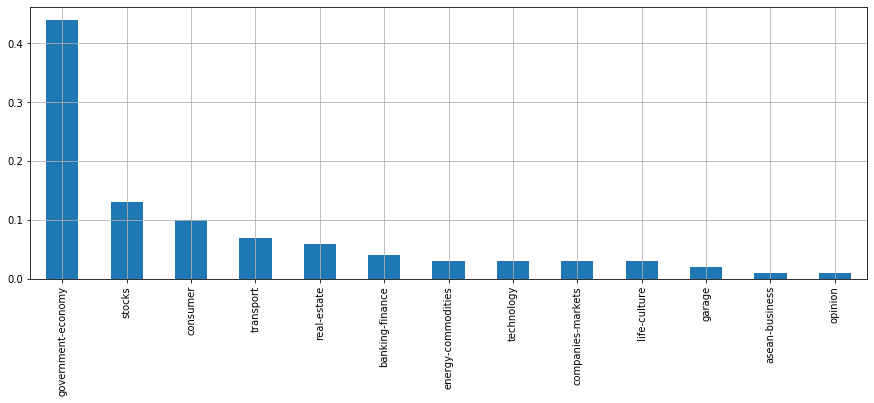

In [15]:
news.Category.value_counts(normalize=True).plot(kind='bar', grid=True,figsize=(15, 5))

In [16]:
news = news.drop_duplicates('Description')
news = news[~news['Description'].isnull()]
#news = news[(news.Description.map(len) > 140) & (news.Description.map(len) <= 300)]

Distribution of description lengths

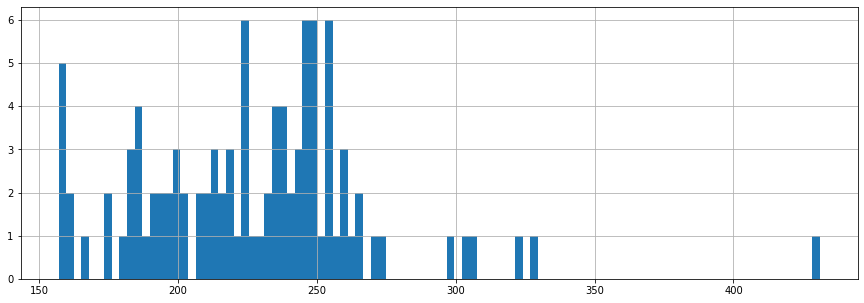

In [17]:
news.Description.map(len).hist(figsize=(15, 5), bins=100)

Text preprocessing for Description column


In [21]:
stop_words = []

f = open('/Users/ernestng/Desktop/projects/webscrap/stopwords.txt', 'r')
for l in f.readlines():
    stop_words.append(l.replace('\n', ''))
    
additional_stop_words = ['t', 'will','a']
stop_words += additional_stop_words

def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text
#function to clean and tokenize texts
def tokenizer(text):
    text = clean_text(text)    
    tokens = [word_tokenize(sent) for sent in sent_tokenize(text)]
    tokens = list(reduce(lambda x,y: x+y, tokens))
    tokens = list(filter(lambda token: token not in (stop_words + list(punctuation)) , tokens))
    return tokens


I tokenize each description and place all under 'tokens' column in the news dataset

In [22]:
news['tokens'] = list(map(tokenizer,news['Description']))
#see how the descriptions are tokenized
for description, tokens in zip(news['Description'].head(5), news['tokens'].head(2)):
    print('---------------------------------------------------------------------------------------------------------------------')
    print('description:', description)
    print()
    print('tokens:', tokens)
print('---------------------------------------------------------------------------------------------------------------------')


---------------------------------------------------------------------------------------------------------------------
description: Of the nearly 200 rated infrastructure issuers in Asia-Pacific, 68 per cent have low exposure to disruption from the coronavirus, 23 per cent have moderate exposure, and 9 per cent have high exposure said Moody's Investors Service in a sector comment released on Thursday. 

tokens: ['rated', 'infrastructure', 'issuers', 'asia', 'pacific', 'cent', 'low', 'exposure', 'disruption', 'coronavirus', 'cent', 'moderate', 'exposure', 'cent', 'high', 'exposure', 'moody', 'investors', 'service', 'sector', 'comment', 'released', 'thursday']
---------------------------------------------------------------------------------------------------------------------
description: [BENGALURU] French catering and food services group Sodexo said on Thursday that second-half revenue could tumble as much as 26 per cent due to government measures to contain the coronavirus, which will 

See most frequent tokens in each category

In [23]:
def keywords(category):
    tokens = news[news['Category'] == category]['tokens']
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(10)

for category in set(news['Category']):
    print('---------------------------------------------------------------------------------------------------------------------')
    print('Category :', category)
    print('top 10 keywords:', keywords(category))
print('---------------------------------------------------------------------------------------------------------------------')


---------------------------------------------------------------------------------------------------------------------
Category : transport
top 10 keywords: [('coronavirus', 6), ('pandemic', 4), ('industry', 4), ('cent', 3), ('flights', 3), ('car', 2), ('year', 2), ('cruise', 2), ('monday', 2), ('raise', 2)]
---------------------------------------------------------------------------------------------------------------------
Category : stocks
top 10 keywords: [('coronavirus', 13), ('shares', 8), ('tuesday', 6), ('investors', 5), ('bengaluru', 5), ('european', 5), ('early', 5), ('signs', 5), ('pandemic', 5), ('rose', 5)]
---------------------------------------------------------------------------------------------------------------------
Category : companies-markets
top 10 keywords: [('coronavirus', 3), ('dollar', 2), ('fitch', 2), ('ratings', 2), ('lowered', 2), ('outlook', 2), ('lippo', 2), ('malls', 2), ('indonesia', 2), ('retail', 2)]
---------------------------------------------------